In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/Colab Notebooks/Music'

/content/drive/My Drive/Colab Notebooks/Music


In [116]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import glob
import os
from collections import Counter
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Softmax, BatchNormalization, Add, Conv2D, Dropout, GlobalAveragePooling2D, concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
import cv2 as cv
from keras.utils import plot_model
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
TRAIN_PATHS = glob.glob(os.path.join("Dataset", "genres", "*", "*.wav")) + glob.glob(os.path.join("Dataset", "rock", "*", "*.wav"))

In [5]:
LABELS = [path.split(os.sep)[-2] for path in TRAIN_PATHS]
le = LabelEncoder()
ENCODED_LABEL = le.fit_transform(LABELS)

In [6]:
TRAIN_PATHS, TEST_PATHS, TRAIN_LABEL, TEST_LABEL = train_test_split(TRAIN_PATHS, ENCODED_LABEL, test_size = .2)

## Experiment 1
  * only use spectrogram extracted from audio. Make it as input to CNN network. I build a simple CNN.
  * Result: gain high accuracy > 95%


In [7]:
def get_featuress_with_librosa(path):
  signal, sr = librosa.load(path)
  melspec = librosa.feature.melspectrogram(signal, sr = sr)
  logmel = librosa.core.power_to_db(melspec).astype(np.float32)
  delta = librosa.feature.delta(melspec).astype(np.float32)
  accelerate = librosa.feature.delta(melspec, order = 2).astype(np.float32)
  feature = np.dstack((logmel, delta, accelerate))
  return feature
def convert_to_feature(path, label):
  [feature, ] = tf.py_function(get_featuress_with_librosa, [path], [tf.string])
  return feature, label

In [ ]:
def _bytes_feature(value):
  return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))
def _int64_feature(value):
  return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))

In [17]:
features = [get_featuress_with_librosa(path) for path in tqdm(TRAIN_PATHS, total = len(TRAIN_PATHS))]

In [11]:
height = np.array([f.shape[0] for f in features]).mean().astype(np.int32)
width = np.array([f.shape[1] for f in features]).mean().astype(np.int32)

In [13]:
height, width

(128, 1293)

In [20]:
features = [cv.resize(f, (width, height)) for f in tqdm(features, total = len(TRAIN_PATHS))]

In [21]:
features = np.array(features)

In [22]:
mean = np.mean(features, axis = (0, 1, 2), keepdims = True)

In [23]:
std = np.std(features, axis = (0, 1, 2), keepdims = True)

In [24]:
X_train = (features - mean) / std

In [25]:
def one_hot(x, y):
  y = tf.one_hot(y, depth = 10)
  return x, y

In [48]:
def conv2d_block(x, out_channels, kernel_size = 3, strides = 1):
  x = Conv2D(out_channels, kernel_size = 3, strides = strides)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [49]:
x = Input(shape = (height, width, 3))
conv_1 = conv2d_block(x, 64, strides = 2)
conv_2 = conv2d_block(conv_1, 128, strides = 2)
conv_3 = conv2d_block(conv_2, 256, strides = 2)
conv_4 = conv2d_block(conv_3, 512, strides = 2)
do_1 = Dropout(rate = .2)(conv_4)
avg_1 = AveragePooling2D()(do_1)
flt = Flatten()(avg_1)
output = Dense(units = 10)(flt)
output = Softmax()(output)
model = Model(inputs = x, outputs = output)

In [50]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 1293, 3)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 63, 646, 64)       1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 646, 64)       256       
_________________________________________________________________
activation (Activation)      (None, 63, 646, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 322, 128)      73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 322, 128)      512       
_________________________________________________________________
activation_1 (Activation)    (None, 31, 322, 128)     

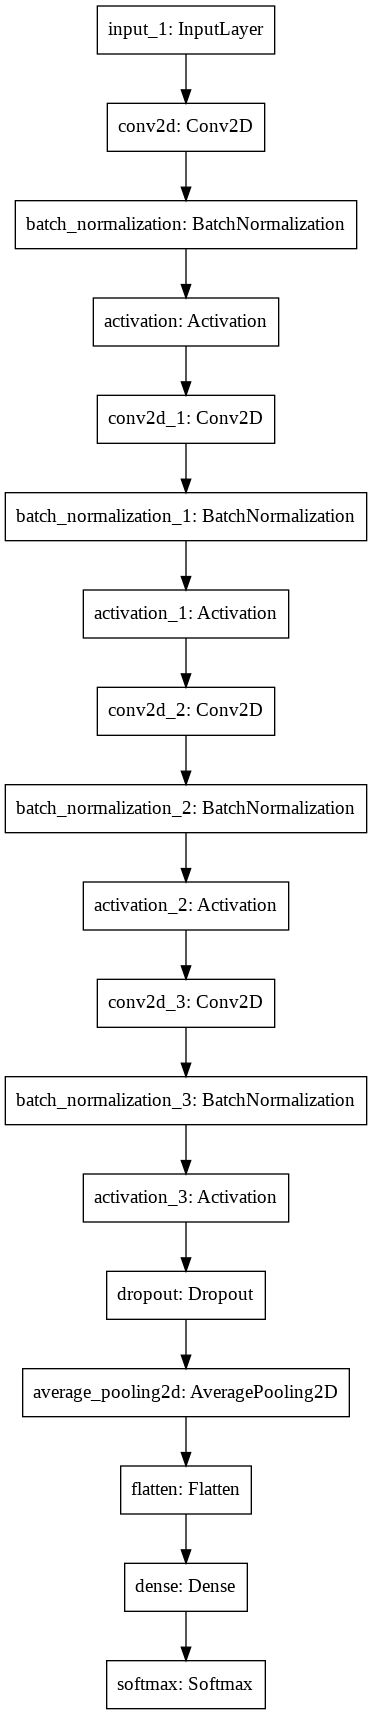

In [51]:
plot_model(model)

In [64]:
dataset = tf.data.Dataset.from_generator(lambda: ImageDataGenerator().flow(X_train, TRAIN_LABEL, batch_size = 32), (tf.float32, tf.int32), output_shapes = ((32, height, width, 3), (32, ))).map(one_hot, num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [46]:
for x, y in dataset.take(5):
  print(x.shape, y.shape, y)

(32, 128, 1293, 3) (32,) tf.Tensor([4 4 2 0 0 4 5 5 4 2 6 7 9 4 8 6 6 3 4 2 1 5 8 7 4 6 7 4 7 7 9 1], shape=(32,), dtype=int32)
(32, 128, 1293, 3) (32,) tf.Tensor([0 8 4 7 2 9 9 4 0 3 7 6 0 8 5 0 9 0 9 0 5 9 1 1 5 6 1 0 3 4 7 0], shape=(32,), dtype=int32)
(32, 128, 1293, 3) (32,) tf.Tensor([0 9 2 3 5 4 8 3 1 1 8 8 3 7 4 4 7 4 9 8 6 5 7 3 8 4 8 0 5 2 3 7], shape=(32,), dtype=int32)
(32, 128, 1293, 3) (32,) tf.Tensor([7 1 2 5 6 5 4 7 2 9 2 3 9 3 5 0 1 0 0 2 1 9 8 0 1 9 0 1 3 5 6 4], shape=(32,), dtype=int32)
(32, 128, 1293, 3) (32,) tf.Tensor([3 6 6 6 4 5 5 3 6 3 2 1 8 9 9 4 7 9 2 6 0 2 8 5 2 1 8 7 8 0 4 8], shape=(32,), dtype=int32)


In [52]:
INIT_LR = 1e-3
model.compile(optimizer = Adam(learning_rate = 1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [53]:
dataset = dataset.repeat().prefetch(tf.data.experimental.AUTOTUNE)

In [58]:
model.fit(dataset, batch_size = 32, epochs = 20, steps_per_epoch = 800 // 32, verbose = 2)

Epoch 1/20
25/25 - 10s - loss: 0.5594 - accuracy: 0.8350
Epoch 2/20
25/25 - 10s - loss: 0.3757 - accuracy: 0.8925
Epoch 3/20
25/25 - 10s - loss: 0.2190 - accuracy: 0.9375
Epoch 4/20
25/25 - 10s - loss: 0.3073 - accuracy: 0.9013
Epoch 5/20
25/25 - 10s - loss: 0.2807 - accuracy: 0.9150
Epoch 6/20
25/25 - 10s - loss: 0.3372 - accuracy: 0.8963
Epoch 7/20
25/25 - 10s - loss: 0.3090 - accuracy: 0.9150
Epoch 8/20
25/25 - 10s - loss: 0.0975 - accuracy: 0.9750
Epoch 9/20
25/25 - 10s - loss: 0.1499 - accuracy: 0.9688
Epoch 10/20
25/25 - 10s - loss: 0.0870 - accuracy: 0.9837
Epoch 11/20
25/25 - 10s - loss: 0.0590 - accuracy: 0.9787
Epoch 12/20
25/25 - 10s - loss: 0.1103 - accuracy: 0.9663
Epoch 13/20
25/25 - 10s - loss: 0.0621 - accuracy: 0.9862
Epoch 14/20
25/25 - 10s - loss: 0.0387 - accuracy: 0.9962
Epoch 15/20
25/25 - 10s - loss: 0.0189 - accuracy: 0.9962
Epoch 16/20
25/25 - 10s - loss: 0.0399 - accuracy: 0.9937
Epoch 17/20
25/25 - 10s - loss: 0.0936 - accuracy: 0.9800
Epoch 18/20
25/25 - 10s

## Experiment 2
  * I will combine spectrogram and meta data that are extracted from audio. I make it as dual input of a simple CNN network.
  * Result: accuracy is far better and more stable than its in experiment 1.

In [72]:
def meta_feature_extraction(path):
  signal, sr = librosa.load(path)
  return [librosa.feature.chroma_stft(y = signal, sr = sr).mean(),
          librosa.feature.spectral_centroid(y = signal, sr = sr).mean(),
          librosa.feature.spectral_bandwidth(y = signal, sr = sr).mean(),
          librosa.feature.spectral_rolloff(y = signal, sr = sr).mean(),
          librosa.feature.zero_crossing_rate(y = signal).mean(),
          librosa.feature.mfcc(y = signal, sr = sr).mean()
          ]

In [75]:
meta_features = np.array([meta_feature_extraction(path) for path in tqdm(TRAIN_PATHS, total = len(TRAIN_PATHS))])

In [92]:
sc_meta = StandardScaler()
meta_features = sc_meta.fit_transform(meta_features)

In [120]:
class DataGenerator(Sequence):
  def __init__(self, img_data, meta_data, labels, batch_size = 32):
    self.img_data = img_data
    self.meta_data = meta_data
    self.labels = labels
    self.batch_size = batch_size
  def __len__(self):
    return self.img_data.shape[0] // self.batch_size
  def __getitem__(self, index):
    batch_img = self.img_data[index * self.batch_size : (index + 1) * self.batch_size]
    batch_meta = self.meta_data[index * self.batch_size : (index + 1) * self.batch_size]
    batch_label = self.labels[index * self.batch_size : (index + 1) * self.batch_size]
    return [batch_img, batch_meta], batch_label

In [108]:
for (a, b), c in DataGenerator(X_train, meta_features, TRAIN_LABEL):
  print(c)
  break

[0 6 0 3 2 5 7 8 7 0 5 6 8 6 0 9 6 9 4 6 7 9 6 1 7 1 5 4 2 7 3 4]


In [128]:
inp1 = Input(shape = (height, width, 3))
conv_1 = conv2d_block(inp1, 64, strides = 2)
conv_2 = conv2d_block(conv_1, 128, strides = 2)
conv_3 = conv2d_block(conv_2, 256, strides = 2)
conv_4 = conv2d_block(conv_3, 512, strides = 2)

inp2 = Input(shape = (6, ))
dense_2 = Dense(units = 128)(inp2)
bn_2 = BatchNormalization()(dense_2)
act_2 = Activation('relu')(bn_2)
do_2 = Dropout(rate = .2)(act_2)

do_1 = Dropout(rate = .2)(conv_4)
avg_1 = GlobalAveragePooling2D()(do_1)

concat = concatenate([avg_1, do_2])
output = Dense(units = 10)(concat)
output = Softmax()(output)
model = Model(inputs = [inp1, inp2], outputs = output)

In [129]:
model.summary()

Model: "functional_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 128, 1293, 3 0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 63, 646, 64)  1792        input_24[0][0]                   
__________________________________________________________________________________________________
batch_normalization_59 (BatchNo (None, 63, 646, 64)  256         conv2d_48[0][0]                  
__________________________________________________________________________________________________
activation_59 (Activation)      (None, 63, 646, 64)  0           batch_normalization_59[0][0]     
______________________________________________________________________________________

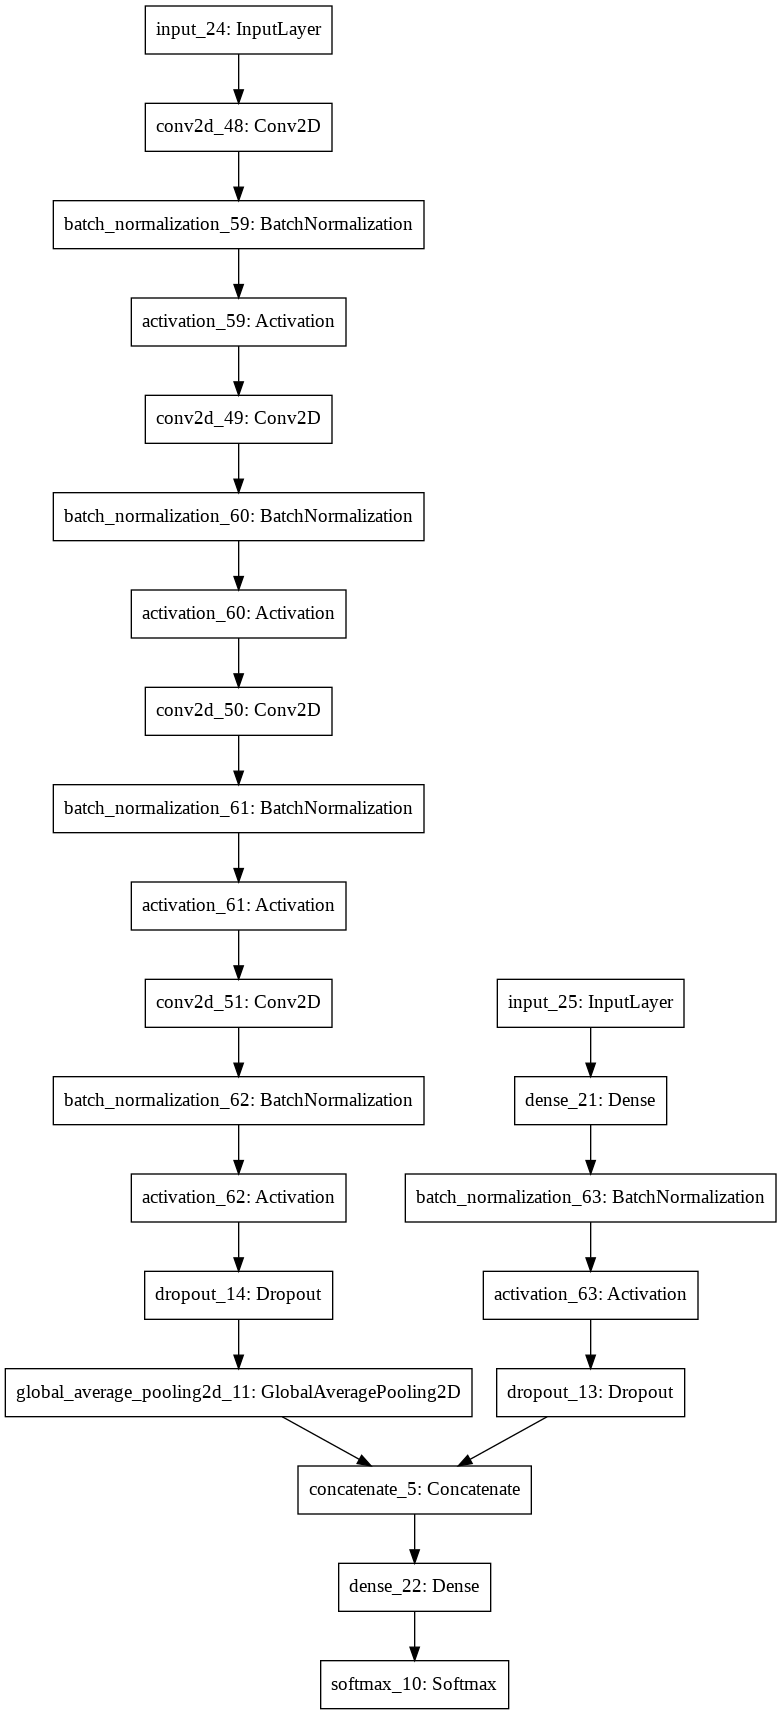

In [130]:
plot_model(model)

In [131]:
ONEHOT_TRAIN_LABELS = to_categorical(TRAIN_LABEL, num_classes = 10)

In [132]:
model.compile(optimizer = Adam(learning_rate = INIT_LR), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit_generator(DataGenerator(X_train, meta_features, ONEHOT_TRAIN_LABELS), epochs = 25, verbose = 2, steps_per_epoch = len(TRAIN_LABEL) // 32)

Epoch 1/25
25/25 - 10s - loss: 1.8052 - accuracy: 0.3550
Epoch 2/25
25/25 - 10s - loss: 1.3530 - accuracy: 0.5025
Epoch 3/25
25/25 - 10s - loss: 1.1052 - accuracy: 0.6212
Epoch 4/25
25/25 - 10s - loss: 0.9855 - accuracy: 0.6637
Epoch 5/25
25/25 - 10s - loss: 0.8666 - accuracy: 0.7138
Epoch 6/25
25/25 - 10s - loss: 0.7816 - accuracy: 0.7350
Epoch 7/25
25/25 - 10s - loss: 0.6940 - accuracy: 0.7675
Epoch 8/25
25/25 - 10s - loss: 0.5984 - accuracy: 0.8125
Epoch 9/25
25/25 - 10s - loss: 0.5506 - accuracy: 0.8313
Epoch 10/25
25/25 - 10s - loss: 0.4707 - accuracy: 0.8575
Epoch 11/25
25/25 - 10s - loss: 0.4129 - accuracy: 0.8813
Epoch 12/25
25/25 - 10s - loss: 0.3806 - accuracy: 0.8925
Epoch 13/25
25/25 - 10s - loss: 0.3496 - accuracy: 0.9038
Epoch 14/25
25/25 - 10s - loss: 0.3021 - accuracy: 0.9225
Epoch 15/25
25/25 - 10s - loss: 0.2311 - accuracy: 0.9513
Epoch 16/25
25/25 - 10s - loss: 0.2151 - accuracy: 0.9538
Epoch 17/25
25/25 - 10s - loss: 0.1658 - accuracy: 0.9762
Epoch 18/25
25/25 - 10s